In [ ]:
!pip install structure_tensor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[7.00367304 7.42750809 7.09280011 5.66745522 9.77785333 7.06334846
 2.47915759 1.57883351 6.97698521 7.19956667 2.5774443  3.41546783
 9.68761168 6.94507098 4.66383259 7.02812695 5.11785874 9.2874137
 7.39769299 6.22439034]
[  4.          11.68421053  19.36842105  27.05263158  34.73684211
  42.42105263  50.10526316  57.78947368  65.47368421  73.15789474
  80.84210526  88.52631579  96.21052632 103.89473684 111.57894737
 119.26315789 126.94736842 134.63157895 142.31578947 150.        ]


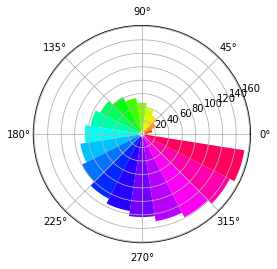

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)

# Compute pie slices
N = 20
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = 10 * np.random.rand(20)
print(radii)
radii2 = 100*np.linspace(0.04,1.5,20)
print(radii2)
width = 2 * np.pi / N
colors = plt.cm.hsv(theta/2/np.pi)

ax = plt.subplot(111, projection='polar')
bars = ax.bar(theta, radii2, width=width, bottom=4, color=colors)

plt.show()

[6.27006608 0.23651317 4.58113469 0.03606364 4.60515486 4.36521781
 2.75173331 1.92674272 0.7445972  2.18418224 1.39598654 2.08035869
 5.44560099 2.39677664 1.82663233 3.63083737 3.36402006 0.70955534
 4.48740507 3.18555206 6.11555973 1.15169304 3.9214384  1.67811972
 2.94977864 2.70645769 1.38549706 4.64443649 4.40750937 5.52045039
 1.76775389 0.2970587  0.10094576 4.50062212 5.63768373 1.66543758
 0.18556373 2.81841731 0.55158742 0.74265074 4.4274987  1.45363963
 5.04390391 2.65425459 5.55333565 1.84297999 3.78278357 4.30878394
 2.79461909 4.99455662 5.58773475 0.55852113 1.78454132 0.42894725
 0.89005021 2.97410303 2.35100783 5.16086795 1.53140374 5.77614423
 0.33499386 0.47726924 5.5065472  6.10450277 6.24471695 2.74309724
 3.69028302 1.03212881 2.31304548 5.23171961 5.61307468 3.92032824
 1.15497385 2.01489038 5.93971317 5.14687127 3.74494591 5.3891298
 0.04066249 3.79920528 1.02613332 6.0776267  2.95553574 1.03454291
 5.24739413 1.10036047 3.31474168 0.1654923  3.5479601  3.89774

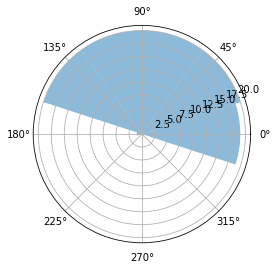

In [28]:
import numpy as np
import matplotlib.pyplot as plt
n_numbers = 100
bins_number = 10 # the [0, 360) interval will be subdivided into this
# number of equal bins
bins = np.linspace(0.0, 2 * np.pi, bins_number + 1)
angles = 2 * np.pi * np.random.rand(n_numbers)
angles2 = np.linspace(0.04,np.pi,n_numbers)
print(angles)
n, _, _ = plt.hist(angles2, bins)

plt.clf()
width = 2 * np.pi / bins_number
ax = plt.subplot(1, 1, 1, projection='polar')
bars = ax.bar(bins[:bins_number], n, width=width, bottom=0.0)
for bar in bars:
    bar.set_alpha(0.5)
plt.show()

In [ ]:
import os
import pandas as pd
import numpy as np
from structure_tensor import eig_special_2d, structure_tensor_2d, eig_special_3d, structure_tensor_3d
import skimage.io 
import matplotlib.pyplot as plt
import scipy as scp
import matplotlib.pyplot as plt
import torch.optim

ValueError: ignored

In [ ]:
import torch

ValueError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))-4

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"img_{idx}.jpeg")
        image = skimage.io.imread(img_path, as_gray = True)

        if self.transform:
          x, y = self.transform(image)
        return x, y

class Transform_structure(object):

    def __call__(self, img):
      scale = 0.25
      rho = 8
      sigma = rho/2
      downsampled_img = scp.ndimage.zoom(img, scale)
      downsampled_S = structure_tensor_2d(downsampled_img, sigma, rho)
      downsampled_val, downsampled_vec = eig_special_2d(downsampled_S)
      downsampled_vec = torch.from_numpy(downsampled_vec)

      transformed_structure_tensor = F.interpolate(downsampled_vec, 400)
      transformed_structure_tensor = transformed_structure_tensor.permute(0, 2, 1)
      transformed_structure_tensor = F.interpolate(transformed_structure_tensor, size=400)
      # transformed_structure_tensor = transformed_structure_tensor.permute(1, 2, 0)

      S = structure_tensor_2d(img, sigma, rho)
      val, vec = eig_special_2d(S)
      # vec = torch.from_numpy(vec).permute(1,2,0)

      img = np.reshape(img, (1, 400, 400))
      img = torch.from_numpy(img)
      input_img = torch.cat((img, transformed_structure_tensor), 0)
      return input_img, vec

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Jan  2 14:21:19 2022


Credit for double_convolution fuction to Abhishek Thakur
https://www.youtube.com/watch?v=u1loyDCoGbE

"""

#%% Import

import numpy as np
import torch
import torch.nn as nn

#%% Functions

# input_conv og output_conv er integers som angiver dimensionen af hhv. input og output
def double_convolution(input_conv, output_conv):
    convolution = nn.Sequential(
        nn.Conv2d(input_conv, output_conv, kernel_size=3, padding="same"),
        nn.ReLU(inplace=True),
        nn.Conv2d(output_conv, output_conv, kernel_size=3, padding="same"),
        nn.ReLU(inplace=True),
        )
    return convolution

#%% Class

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=1)
        
        self.down_conv_1 = double_convolution(3, 16)
        self.down_conv_2 = double_convolution(16, 32)
        self.down_conv_3 = double_convolution(32, 64)
        self.down_conv_4 = double_convolution(64, 128)
        self.down_conv_5 = double_convolution(128, 256)
        
        self.up_trans_1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.up_trans_2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.up_trans_3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2)
        self.up_trans_4 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2)
        self.up_trans_5 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=2, stride=2)
        
        self.up_conv_1 = double_convolution(256, 128)
        self.up_conv_2 = double_convolution(128, 64)
        self.up_conv_3 = double_convolution(64, 32)
        self.up_conv_4 = double_convolution(32, 16)
        
        self.out = nn.Conv2d(in_channels=16, out_channels=2, kernel_size=1)

    def forward(self, input_data):
        # Encoder 
        x1 = self.down_conv_1(input_data)
        print(x1.shape)
        x2 = self.max_pool(x1)
        x3 = self.down_conv_2(x2)
        print(x3.shape)
        x4 = self.max_pool(x3)
        x5 = self.down_conv_3(x4)
        print(x5.shape)
        x6 = self.max_pool(x5)
        x7 = self.down_conv_4(x6)
        print(x7.shape)
        x8 = self.max_pool(x7)
        x9 = self.down_conv_5(x8)
        print(x9.shape)
        
        # Decoder which concatenates from the encoder layers
        y = self.up_trans_1(x9)
        y = self.up_conv_1(torch.cat([y,x7], 1))
        y = self.up_trans_2(y)
        print(y.shape)
        y = self.up_conv_2(torch.cat([y,x5], 1))
        y = self.up_trans_3(y)
        y = self.up_conv_3(torch.cat([y,x3], 1))
        y = self.up_trans_4(y)
        y = self.up_conv_4(torch.cat([y,x1], 1))

        # Apply final conv3d layer and sigmoid        
        y = self.out(y)
        y_out = torch.sigmoid(y)

        return y_out
    


In [ ]:
torch.__version__

'1.12.1+cu113'

In [ ]:
!pip install torch==1.13.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████████████████  | 834.1 MB 1.2 MB/s eta 0:00:46tcmalloc: large alloc 1147494400 bytes == 0x39322000 @  0x7f14edd03615 0x5d631c 0x51e4f1 0x51e67b 0x4f7585 0x49ca7c 0x4fdff5 0x49caa1 0x4fdff5 0x49ced5 0x4f60a9 0x55f926 0x4f60a9 0x55f926 0x4f60a9 0x55f926 0x5d7c18 0x5d9412 0x586636 0x5d813c 0x55f3fd 0x55e571 0x5d7cf1 0x49ced5 0x55e571 0x5d7cf1 0x49ec69 0x5d7c18 0x49ca7c 0x4fdff5 0x49ced5
     |████████████████████████████████| 890.2 MB 4.7 kB/s 
     |████████████████████████████████| 849 kB 54.6 MB/s 
     |████████████████████████████████| 21.0 MB 1.3 MB/s 
     |████████████████████████████████| 317.1 MB 34 kB/s 
     |████████████████████████████████| 557.1 MB 11 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 

In [ ]:
import torch==1.

ValueError: ignored

In [ ]:
!pip uninstall torchvision

Found existing installation: torchvision 0.13.1+cu113
Uninstalling torchvision-0.13.1+cu113:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/torchvision-0.13.1+cu113.dist-info/*
    /usr/local/lib/python3.8/dist-packages/torchvision.libs/libcudart.053364c0.so.11.0
    /usr/local/lib/python3.8/dist-packages/torchvision.libs/libjpeg.ceea7512.so.62
    /usr/local/lib/python3.8/dist-packages/torchvision.libs/libnvjpeg.90286a3c.so.11
    /usr/local/lib/python3.8/dist-packages/torchvision.libs/libpng16.7f72a3c5.so.16
    /usr/local/lib/python3.8/dist-packages/torchvision.libs/libz.1328edc3.so.1
    /usr/local/lib/python3.8/dist-packages/torchvision/*
Proceed (y/n)? y
  Successfully uninstalled torchvision-0.13.1+cu113


In [ ]:
!pip install torchvision==0.14.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.3 MB 47.8 MB/s 


In [ ]:
LOADPATH = "/content/drive/MyDrive/Deep Learning/Data/model_hpc_ba2-lr0.0001-ep100.pth.tar"
model = UNet()
LEARNING_RATE = 0.0001
BATCH_SIZE = 2 ## For at teste pr 1 billede og se hvor hurtigt det går
NUM_EPOCHS = 100
Drop_P = 0.2

out = 0
y = 0
    
# Set device, send model to device
device = "cuda" if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Loss function
loss_func = torch.nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Dataload
transformed_dataset = CustomImageDataset(img_dir="/content/drive/MyDrive/Deep Learning/trainingimages/", 
                          transform=Transform_structure())
    
dataloader = DataLoader(transformed_dataset, batch_size=BATCH_SIZE,
                    shuffle=True)

checkpoint = torch.load(LOADPATH, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch_nr = checkpoint['epoch']
loss = checkpoint['loss']
total_loss = checkpoint['total_loss']
loss_pr_epoch = checkpoint['loss_pr_epoch']

model.eval()

RuntimeError: ignored